# Imports

In [11]:
import pandas as pd
from pathlib import Path
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
import datetime

import os, math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans, KernelKMeans, silhouette_score
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering

# Loading Data

In [12]:
with open("IS-thesis-pattern-extraction/options.txt", 'r') as f:
    options = f.readlines()
    options = {option.split("=")[0]: option.split("=")[1].strip() for option in options}
print(options)

{'hanoi_scenario_dir': 'C:\\Users\\mjnst\\Desktop\\Thesis\\Hanoi_CMH\\Scenario-1', 'RUG_dir': 'C:\\Users\\mjnst\\Desktop\\Thesis\\RUG_data_5years', 'RUG_raw_csv': 'C:\\Users\\mjnst\\Desktop\\Thesis\\rug_csv.csv', 'RUG_timeseries': 'C:\\Users\\mjnst\\Desktop\\Thesis\\rug_timeseries.pkl', 'RUG_obfuscated': 'C:\\Users\\mjnst\\Desktop\\Thesis\\obfuscated_data.pkl'}


In [13]:
RUG = pd.read_pickle(options['RUG_obfuscated'])

# Preparing and Transforming Data

In [14]:
RUG.interpolate(method='linear', inplace=True, limit=20)

In [15]:
groups = RUG['Location 2 - consumption'].groupby(pd.Grouper(freq='D'))

# get the calender date of the groups
days = list(groups.first().index.strftime('%Y:%m:%d'))

gro = [groups.get_group(x).reset_index(drop=True) for x in groups.groups]

temp = pd.concat(gro, axis=1, keys=days)

temp.index = pd.date_range("00:00", "23:59", freq="1min").strftime('%H:%M')

# drop all columns of temp dataframe which contain nan values
temp.dropna(axis=1, how='any', inplace=True)

In [16]:
temp = temp[::10]

In [17]:
train_percentage = 0.8
train_size = int(len(temp.columns) * train_percentage)
train_size

1702

In [18]:
train = temp.iloc[:, :train_size]
test = temp.iloc[:, train_size:]

In [19]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [20]:
scaled_list_train = [train[col] for col in train]

# for i in range(len(scaled_list_tain)):
#     scaler = MinMaxScaler()
#     scaled_list_tain[i] = MinMaxScaler().fit_transform(scaled_list_tain[i].to_numpy().reshape(-1, 1))
#     scaled_list_tain[i]= scaled_list_tain[i].reshape(len(scaled_list_tain[i]))

# scaled_list_train = np.nan_to_num(scaled_list_tain, copy=False, nan=0.0)
scaled_list_train = scaler.fit_transform(scaled_list_train)
scaled_list_train

array([[0.17881265, 0.17840637, 0.18230088, ..., 0.09634284, 0.09634284,
        0.12386668],
       [0.04017064, 0.03969576, 0.04424779, ..., 0.13174732, 0.13174732,
        0.1581928 ],
       [0.15926058, 0.22678519, 0.23379805, ..., 0.09465692, 0.09465692,
        0.12223211],
       ...,
       [0.02986136, 0.02724738, 0.05734513, ..., 0.17659299, 0.16445432,
        0.19578807],
       [0.12584429, 0.13608185, 0.09132743, ..., 0.07341423, 0.069368  ,
        0.16048121],
       [0.07038748, 0.0784636 , 0.08495575, ..., 0.07341423, 0.05115998,
        0.08790598]])

In [21]:
scaled_list_test = [test[col] for col in test]

# for i in range(len(scaled_list_test)):
#     scaler = MinMaxScaler()
#     scaled_list_test[i] = MinMaxScaler().fit_transform(scaled_list_test[i].to_numpy().reshape(-1, 1))
#     scaled_list_test[i]= scaled_list_test[i].reshape(len(scaled_list_test[i]))

# scaled_list_test = np.nan_to_num(scaled_list_test, copy=False, nan=0.0)
scaled_list_test = scaler.transform(scaled_list_test)

scaled_list_test

array([[0.0234625 , 0.02084535, 0.0339823 , ..., 0.16850054, 0.24537884,
        0.19382658],
       [0.14077497, 0.11474176, 0.14654867, ..., 0.21300902, 0.20289347,
        0.15851971],
       [0.13224316, 0.04218544, 0.04035398, ..., 0.18670856, 0.17456989,
        0.21148001],
       ...,
       [0.01919659, 0.00804129, 0.05309735, ..., 0.08959913, 0.13208451,
        0.08790598],
       [0.08745111, 0.0101753 , 0.01486726, ..., 0.1604081 , 0.08352979,
        0.11928987],
       [0.06612158, 0.11687577, 0.21663716, ..., 0.12399206, 0.04913687,
        0.08594449]])

# Principal Component Analysis

Shape before PCA:  (1702, 144)
Shape after PCA:  (1702, 10)


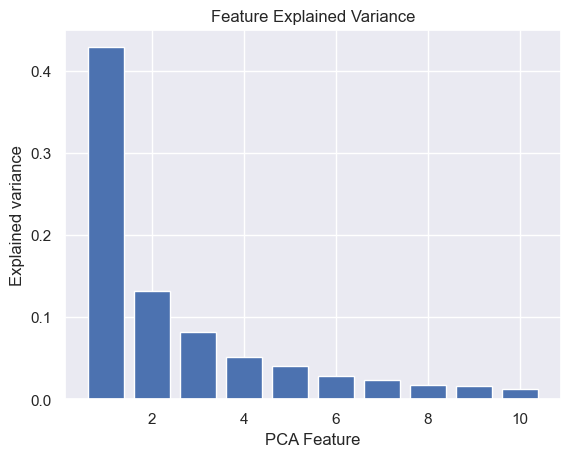

In [22]:
sns.set()
 
# Reduce from 4 to 3 features with PCA
# pca = PCA(n_components=cluster_count)
pca = PCA(n_components=0.85, svd_solver='full')
 
# Fit and transform data
pca_features = pca.fit_transform(scaled_list_train)
 

print('Shape before PCA: ', scaled_list_train.shape)
print('Shape after PCA: ', pca_features.shape)

pca_df = pd.DataFrame(
    data=pca_features)

# Bar plot of explained_variance
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
 
 
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

# Added K-means

In [23]:
wcss = []
silhouette_scores = []
for i in range(1,10):
    print(i)
    kmeans_pca = TimeSeriesKMeans(n_clusters=i, metric="dtw", n_jobs=-1).fit(pca_features)
    wcss.append(kmeans_pca.inertia_)
    # print("silhouette_score")
    # try:
    #     silhouette_scores.append(silhouette_score(pca_features, kmeans_pca.labels_, n_jobs=-1))
    # except:
    #     silhouette_scores.append(0)

1
2


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(range(1,10), wcss, marker='o', linestyle='--')
plt.title('K-means with PCA')
plt.ylabel('WCSS')
plt.xlabel('Number of clusters')

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(range(1,10), silhouette_scores, marker='o', linestyle='--')
plt.title('K-means with PCA')
plt.ylabel('Silhouette score')
plt.xlabel('Number of clusters')

from these graphs, we see that the elbow is at around 3, so we will use 3 clusters for the k-means algorithm.

In [34]:
from collections import Counter
kmeans_pca = TimeSeriesKMeans(n_clusters=4, metric="dtw", n_jobs=-1).fit(pca_features)
train_pca_features = kmeans_pca.predict(pca_features)
counts = dict(Counter(train_pca_features))

c:\Users\mjnst\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1702 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


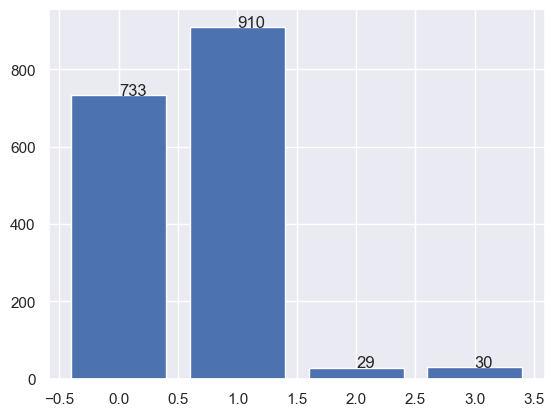

In [35]:
plt.bar(counts.keys(), counts.values())

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

addlabels(counts.keys(), list(counts.values()))

plt.show()


# Train different lstm models

In [42]:
print(train_pca_features)

[0 0 0 ... 1 0 1]


# Predict test data clusters

In [26]:
test_pca_features = kmeans_pca.predict(scaled_list_test)

c:\Users\mjnst\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 426 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


<BarContainer object of 2 artists>

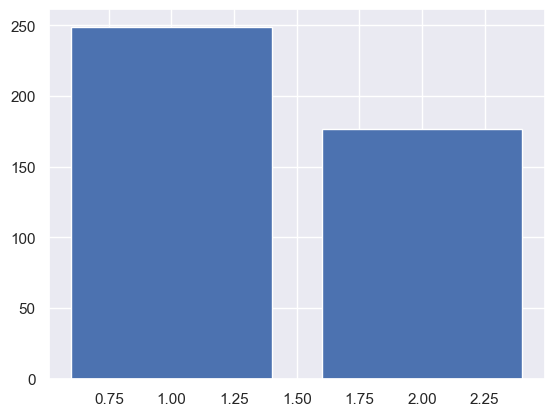

In [27]:
plt.bar(dict(Counter(test_pca_features)).keys(), dict(Counter(test_pca_features)).values())